<a href="https://colab.research.google.com/github/flying-bear/kompluxternaya/blob/master/Assignment_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 6

[3 points] Delelop language model, which generates texts from wikipedia.   
Use WikiText-2 dataset, also available in `torchtext.datasets`.  
Use `sentencepiece` or `tokenizers` library for text tokenization. Pay attention to vocab size, probably subword tokens are better.    
Your model should be autogressive RNN.  
[1 point] Plot train and validation loss depending on the number of iterations of gradient decent.  
[1 point] Try to use together (`sentencepiece` or `tokenizers`), `torchtext.datasets`, and `torchtext.data.BPTTIterator`  

<img src="https://raw.githubusercontent.com/thedenaas/hse_seminars/master/2019/seminar_9/images/lm.jpg" style="height:300px">

Text generation should be terminated when either max length is reached or terminal symbol is generated.  
Explore several inference techniques:
1. [1 point] Argmax
1. [1 point] Beamsearch
1. [1 point] Sampling from probabilty distribution with temperature
1. [1 point] Nucleus sampling
1. [1 point] Top-k sampling


For every method you should provide implemented code and generated examples. Each example must contain at least 10 words (not subword tokens).

Readings:
https://arxiv.org/abs/1904.09751

In [1]:
!pip install tokenizers

     |████████████████████████████████| 3.7MB 3.3MB/s 


In [0]:
import nltk
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import spacy

from sklearn import metrics
from tqdm import tqdm, tqdm_notebook
from tokenizers import SentencePieceBPETokenizer
from scipy.ndimage.filters import gaussian_filter1d

import torch as tt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.autograd import Variable as V

from torchtext.data import Field, BPTTIterator
from torchtext.datasets import WikiText2, LanguageModelingDataset

SEED = 42
np.random.seed(SEED)

In [0]:
device = tt.device('cuda') if tt.cuda.is_available() else tt.device('cpu')

## Preprocessing

In [4]:
WikiText2.download(root='content')

downloading wikitext-2-v1.zip


wikitext-2-v1.zip: 100%|██████████| 4.48M/4.48M [00:00<00:00, 19.1MB/s]


extracting


'content/wikitext-2/wikitext-2'

In [0]:
data_dir = 'content/wikitext-2/wikitext-2'

In [0]:
with open(data_dir + '/wiki.valid.tokens', 'r') as f:
  valid = f.read()
with open(data_dir + '/wiki.train.tokens', 'r') as f:
  train = f.read()
with open(data_dir + '/wiki.test.tokens', 'r') as f:
  test = f.read()

In [7]:
test[:300]

' \n = Robert <unk> = \n \n Robert <unk> is an English film , television and theatre actor . He had a guest @-@ starring role on the television series The Bill in 2000 . This was followed by a starring role in the play Herons written by Simon Stephens , which was performed in 2001 at the Royal Court The'

добавим символы сепараторы

In [0]:
end = ['.', '\n', '!', '?', '…']

In [0]:
def make_eos(text, eos_symbols, eos_token='<eos>', start_token='<start>'):
  """
  cleans text of empty sentences and replaces eos_symbols in a text with eos_token and adds start_token befor each sentence

  :param text: str, text
  :param eos_symbols: list of str, symbols that signify end of sentence
  :param eos_token: str, what to replace eos_symbols with, optional, deafault '<eos>' 
  :param str_token: str, what to indicate sentence beginnings, optional, deafault '<start>'
  :return: str, text with eos_symbols replaced with eos_token
  """
  sep = eos_token + ' ' + start_token
  text = re.sub('\s+', ' ', text)
  for i in eos_symbols:
    text = text.replace(i, sep)
  empty = sep + ' ' + eos_token
  while empty in text: 
    text = text.replace(empty, eos_token)
  return text.strip()

In [10]:
tokenizer_test_text = make_eos(test, end)
tokenizer_test_text[:100]

'= Robert <unk> = Robert <unk> is an English film , television and theatre actor <eos> <start> He had'

средняя длина предложения от сепаратора до сепаратора (число пробелов +1)

In [11]:
np.mean([len(sent.split()) for sent in make_eos(train, end).split('<eos> <start>')])

23.575564652402598

In [0]:
tokenizer_train_text = make_eos(train, end)
with open('content/train.txt', 'w') as f:
  f.write(tokenizer_train_text)

In [0]:
tokenizer_valid_text = make_eos(valid, end)
with open('content/valid.txt', 'w') as f:
  f.write(tokenizer_valid_text)

In [0]:
tokenizer_test_text = make_eos(test, end)
with open('content/test.txt', 'w') as f:
  f.write(tokenizer_test_text)

единичных символов

In [15]:
len(set(train).union(set(valid)))

283

In [16]:
tokenizer = SentencePieceBPETokenizer()
tokenizer.add_special_tokens(['<eos>', '<start>','<unk>'])

3

In [0]:
tokenizer.train(['content/valid.txt', 'content/train.txt', 'content/test.txt'], vocab_size=20000)

In [18]:
tokenizer.encode("<start> How are you, my dear Tamagotchi <unk> <eos> lkjkds").tokens

['<start>',
 '▁How',
 '▁are',
 '▁you',
 ',',
 '▁my',
 '▁de',
 'ar',
 '▁Tam',
 'ag',
 'ot',
 'ch',
 'i',
 '▁',
 '<unk>',
 '▁',
 '<eos>',
 '▁l',
 'k',
 'j',
 'k',
 'ds']

In [19]:
tokenizer.token_to_id('<eos>')

0

hпосчитаем среднюю длину последовательности в токенах нашего токенайзера

In [20]:
np.mean([len(tokenizer.encode(sent).ids) for sent in make_eos(train, end).split('<eos> <start>')])

27.033902944046456

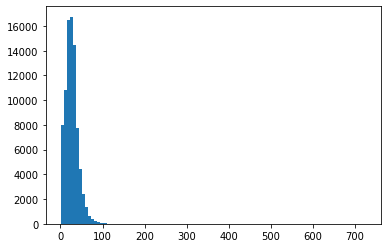

In [21]:
plt.hist([len(tokenizer.encode(sent).ids) for sent in make_eos(train, end).split('<eos> <start>')], bins=100);

In [0]:
batch_size = 128
seq_length = 40

## torchtext

In [0]:
def eosed_tokenizer(tokenizer, text, eos_symbols=['.', '\n', '!', '?', '…'], eos_token='<eos>', start_token='<start>'):
  """
  cleans text of empty sentences adds start and eos symbols and then tokenizes using a trained tokenizers.tokenizer

  :param tokenizer: tokenizers.tokenizer, trained
  :param text: str, text
  :param eos_symbols: list of str, symbols that signify end of sentence, optional, default ['.', '\n', '!', '?', '…']
  :param eos_token: str, what to replace eos_symbols with, optional, deafault '<eos>'
  :param str_token: str, what to indicate sentence beginnings, optional, deafault '<start>'
  :return: list of str, tokens
  """
  eosed = make_eos(text, eos_symbols, eos_token, start_token)
  return tokenizer.encode(eosed).tokens

In [24]:
eosed_tokenizer(tokenizer, 'I hate programming omg I hate it so much')

['▁I',
 '▁hate',
 '▁programming',
 '▁o',
 'm',
 'g',
 '▁I',
 '▁hate',
 '▁it',
 '▁so',
 '▁much']

In [0]:
TEXT = Field(lower=True, tokenize=lambda s: eosed_tokenizer(tokenizer, s), include_lengths=False, batch_first=True)

In [26]:
trn, vld, tst = WikiText2.splits(TEXT)

wikitext-2-v1.zip:   0%|          | 0.00/4.48M [00:00<?, ?B/s]

downloading wikitext-2-v1.zip


wikitext-2-v1.zip: 100%|██████████| 4.48M/4.48M [00:00<00:00, 19.4MB/s]


extracting


In [0]:
TEXT.build_vocab(trn, vld, tst, min_freq=10)

In [0]:
trn_itr, vld_itr, tst_itr = BPTTIterator.splits((trn, vld, tst),
    batch_size=batch_size,
    bptt_len=seq_length, # this is where we specify the sequence length
    repeat=False,
    device=device)

In [0]:
def to_text(seq):
  return [TEXT.vocab.itos[v] for v in seq]

In [30]:
b = next(iter(trn_itr))
vars(b).keys()

dict_keys(['batch_size', 'dataset', 'fields', 'text', 'target'])

In [31]:
print(b.text[:5, :3])
print(b.target[:5, :3])

tensor([[   2,    5,  512],
        [   4, 4470, 1410],
        [  12,  449,    7],
        [5472,  224,    3],
        [6046,  704,    2]], device='cuda:0')
tensor([[   4, 4470, 1410],
        [  12,  449,    7],
        [5472,  224,    3],
        [6046,  704,    2],
        [1166,    5,    0]], device='cuda:0')


In [32]:
print(b.text[:5, 0])
print(b.target[:5, 0])

tensor([   2,    4,   12, 5472, 6046], device='cuda:0')
tensor([   4,   12, 5472, 6046, 1166], device='cuda:0')


In [33]:
print(to_text(b.text[10:25, 1]))

['▁st', '<eos>', '▁', '<start>', '▁louis', '▁blues', '▁,', '▁all', '▁made', '▁the', '▁playoff', '▁during', '▁the', '▁2011', '▁–']


## RNN

In [0]:
class MyModel(nn.Module):
    
    def __init__(self, vocab_size, embed_size, hidden_size):
        super(MyModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        
        self.rnn = nn.LSTM(input_size=embed_size,
                           hidden_size=hidden_size,
                           bidirectional=True,
                           batch_first=True,
                          )
        
        self.fc = nn.Linear(hidden_size * 2, vocab_size)
        
        self.init_weights()
        
    def init_weights(self):
        nn.init.uniform_(self.embedding.weight)
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)
        
    def forward(self, batch):
        
        if hasattr(batch, 'text'):
          x = batch.text.T
        else:
          x = batch
        
        x = self.embedding(x)

            
        x, _ = self.rnn(x)
        
        x = self.fc(x)
        return x.transpose(1,2)

In [0]:
def _train_epoch(model, iterator, optimizer, criterion, curr_epoch):

    model.train()
    train_losses = []
    running_loss = 0

    n_batches = len(iterator)
    iterator = tqdm_notebook(iterator, total=n_batches, desc=f'epoch {curr_epoch + 1}', leave=True)

    for i, batch in enumerate(iterator):
        optimizer.zero_grad()
        pred = model(batch)
        loss = criterion(pred, batch.target.T)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        curr_loss = loss.data.cpu().detach().item()
        
        loss_smoothing = i / (i+1)
        running_loss = loss_smoothing * running_loss + (1 - loss_smoothing) * curr_loss

        iterator.set_postfix(loss=f'{running_loss:.5f}')

    return running_loss, train_losses

In [0]:
def _test_epoch(model, iterator, criterion):
    model.eval()
    valid_losses = []
    epoch_loss = 0

    n_batches = len(iterator)
    with tt.no_grad():
        for batch in iterator:
            pred = model(batch)
            loss = criterion(pred, batch.target.T)
            valid_losses.append(loss.item())
            epoch_loss += loss.data.item()

    return epoch_loss / n_batches , valid_losses

In [0]:
def nn_train(model, train_iterator, valid_iterator, criterion, optimizer, n_epochs=100,
          scheduler=None, early_stopping=0):
    model = model.to(device)
    criterion = criterion.to(device)
    prev_loss = 100500
    es_epochs = 0
    best_epoch = None
    history = pd.DataFrame()
    all_train_losses = []
    all_valid_losses = []

    for epoch in range(n_epochs):
        train_loss, epoch_train_losses = _train_epoch(model, train_iterator, optimizer, criterion, epoch)
        valid_loss, epoch_valid_losses = _test_epoch(model, valid_iterator, criterion)
        all_train_losses += epoch_train_losses
        all_valid_losses += epoch_valid_losses

        print(f'validation loss {valid_loss:.5f}')

        record = {'epoch': epoch + 1, 'train_loss': train_loss, 'valid_loss': valid_loss}
        history = history.append(record, ignore_index=True)

        if early_stopping > 0:
            if valid_loss > prev_loss:
                es_epochs += 1
            else:
                es_epochs = 0

            if es_epochs >= early_stopping:
                best_epoch = history[history.valid_loss == history.valid_loss.min()].iloc[0]
                print(f"Early stopping! best epoch: {best_epoch['epoch'] + 1} val {best_epoch['valid_loss']:.5f}")
                break

            prev_loss = min(prev_loss, valid_loss)
    return history, all_train_losses, all_valid_losses

In [0]:
model = MyModel(vocab_size=len(TEXT.vocab.itos),
                embed_size=100,
                hidden_size=128,
               )

optimizer = optim.Adam(model.parameters())
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)

# padding does count into loss (rnn padding thing removed, as there's virtually no padding)
criterion = nn.CrossEntropyLoss(ignore_index=1)



In [39]:
history_df, train_losses, valid_losses = nn_train(model, trn_itr, vld_itr, criterion, optimizer, scheduler=scheduler, 
        n_epochs=15, early_stopping=2)


validation loss 4.07759



validation loss 2.92871



validation loss 2.16963



validation loss 1.62149



validation loss 1.22614



validation loss 0.94183



validation loss 0.73597



validation loss 0.58681



validation loss 0.48115



validation loss 0.40516



validation loss 0.35084



validation loss 0.31187



validation loss 0.28279



validation loss 0.26113



validation loss 0.24460


## Plot history

In [40]:
history_df.tail()

,epoch,train_loss,valid_loss
10,11.0,0.285369,0.350837
11,12.0,0.237320,0.311871
12,13.0,0.203129,0.282794
13,14.0,0.178213,0.261130
14,15.0,0.159664,0.244601


In [41]:
print(len(train_losses))
print(len(valid_losses))

7545
780


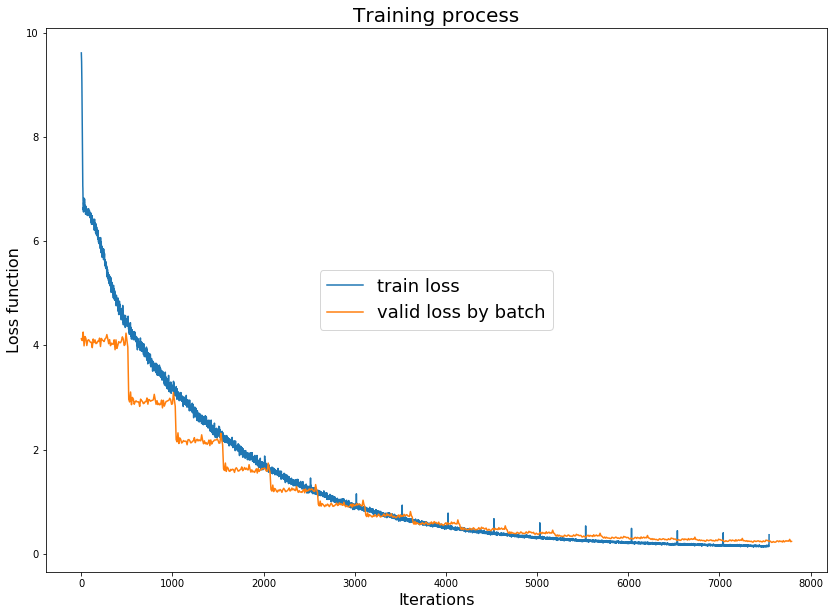

In [42]:
plt.figure(figsize=(14, 10))
plt.plot(range(len(train_losses)), train_losses, np.array(range(len(valid_losses)))*10, valid_losses)
plt.legend(('train loss', 'valid loss by batch'),
           loc='center', prop={'size': 18})
plt.title('Training process', fontsize=20)
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('Loss function', fontsize=16)
plt.show()

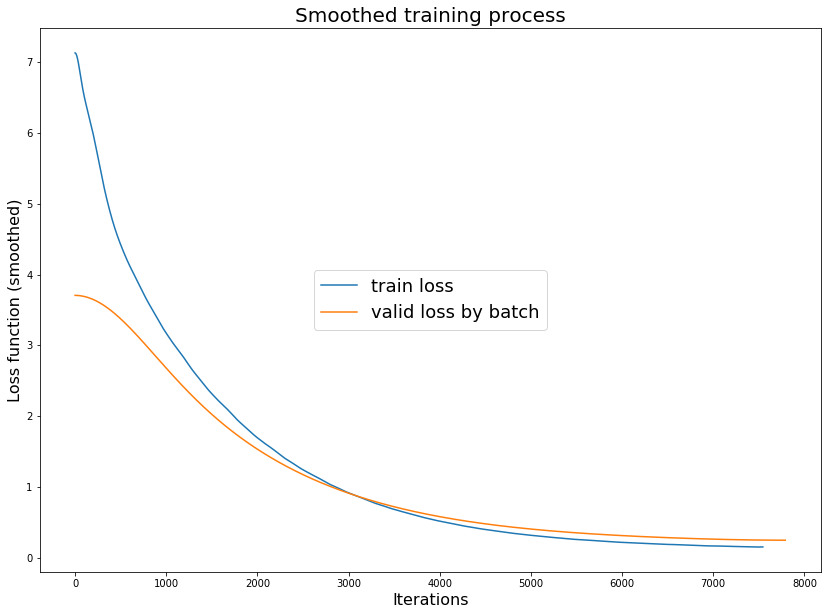

In [43]:
smooth = lambda y: gaussian_filter1d(y, sigma=50)

plt.figure(figsize=(14, 10))
plt.plot(range(len(train_losses)), smooth(train_losses), np.array(range(len(valid_losses)))*10, smooth(valid_losses))
plt.legend(('train loss', 'valid loss by batch'),
           loc='center', prop={'size': 18})
plt.title('Smoothed training process', fontsize=20)
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('Loss function (smoothed)', fontsize=16)
plt.show()

## Prediction

In [0]:
model = model.cpu()

In [0]:
max_len = 40

### prepare text

In [0]:
id_to_token = lambda tok_id: TEXT.vocab.itos[tok_id]

In [0]:
token_to_id = lambda tok: TEXT.vocab.stoi[tok]

In [0]:
def join_tok(tok_list, eos_token='<eos>'): 
  if tok_list[-1] == eos_token:
    return ''.join(tok_list[:-1]).replace('▁', ' ').strip() + ' ' + eos_token
  else:
    return ''.join(tok_list).replace('▁', ' ').strip()

In [49]:
join_tok(['<start>', '▁abc', 'def', '▁ghi'])

'<start> abcdef ghi'

In [50]:
join_tok(['<start>', '▁abc', 'def', '▁ghi', '<eos>'])

'<start> abcdef ghi <eos>'

In [51]:
eos = token_to_id('<eos>')
eos

4

In [52]:
start = token_to_id('<start>')
start

6

### prediction func

In [0]:
def predict_from_start(model, prob_func, max_len=40, eos='<eos>'):
  """
  autoregressive language modeling prediction

  :param model: trained torch model, predicts logits torch tensor (of shape (batch, vocab, seq)) form batch tensor (of shape (batch, seq))
  :param prob_func: function, takes torch tensor of logits and return an int (token number)
  :param max_len: int, maximal number of words produced, optional, default 40
  :param eos: str, end of sentence token, optional, default '<eos>'
  :return: str, sequence
  """
  id_eos = token_to_id(eos)
  with tt.no_grad():
      tok = start
      seq = [tok]
      i = 0
      while i < max_len and tok != id_eos:
        i += 1
        pred = model(tt.tensor([seq]))[:,:,-1]
        tok = prob_func(pred)
        seq.append(tok)
  return join_tok(to_text(seq))

### Argmax

In [0]:
argmax = lambda prob: tt.argmax(prob).item()

In [55]:
argmax(tt.tensor([[[1],[5],[3]]]))

1

In [56]:
argmax(tt.tensor([[[1, 2, 3]]]))

2

In [173]:
predict_from_start(model, argmax)

'<start> the <unk> <eos>'

### Sampling from probabilty distribution with temperature

In [0]:
def soft_with_temp(logits_tsr, tau=1):
  """
  computes softmax with temperature tau
  
  :param logits_tsr: torch tensor of logits
  :param tau: float, temperature, optional, default 1
  :return: np.array, softmax with temperature
  """
  logits_tsr = logits_tsr.detach()
  out = tt.exp(logits_tsr/tau)/tt.sum(tt.exp(logits_tsr/tau))  # F.softmax(logits/tau, dim=0)
  out = out.squeeze()
  if np.sum(out.numpy()) != 1:
    return out.numpy()/np.sum(out.numpy())
  else:
    return out.numpy()

In [59]:
logits = model(tt.tensor([[123]])).detach().squeeze()
soft_probs = soft_with_temp(logits)
soft_probs

array([1.4084876e-02, 3.7258428e-07, 6.0511444e-02, ..., 4.2941850e-09,
       7.5573885e-09, 3.7184420e-09], dtype=float32)

In [60]:
F.softmax(logits, dim=0).numpy()

array([1.4084911e-02, 3.7258525e-07, 6.0511597e-02, ..., 4.2942001e-09,
       7.5573992e-09, 3.7184475e-09], dtype=float32)

In [61]:
np.sum(F.softmax(logits, dim=0).numpy())

1.0000025

In [62]:
np.sum(soft_probs)

1.0

In [0]:
def sample_with_temp(logits_tsr, tau=1):
  """
  samples from a distribution with temperature

  :param logits_tsr: torch tensor of logits
  :param tau: float, temperature, optional, default 1
  :return: int, id of the element selected
  """
  soft_probs = soft_with_temp(logits_tsr, tau=tau)
  return np.random.choice(len(soft_probs), 1, p=soft_probs)[0]

In [64]:
sample_with_temp(logits, 0.5)

5

####**predict**

In [65]:
current = predict_from_start(model, sample_with_temp)
while len(current.split()) < 12:
  current = predict_from_start(model, sample_with_temp)

print(current)


<start> busch spent later the united states again album off the invention held in the united states in august mall to be named as previous as her son <eos>


In [66]:
current = predict_from_start(model, lambda logit_tsr: sample_with_temp(logit_tsr, tau=0.2)) 
while len(current.split()) < 12:
  current = predict_from_start(model, lambda logit_tsr: sample_with_temp(logit_tsr, tau=0.2)) 

print(current)

<start> the <unk> <unk> , the <unk> , and the <unk> , and the first <unk> <eos>


### Top-k sampling

In [0]:
logits = model(tt.tensor([[123]])).detach().squeeze()

In [68]:
ex = tt.tensor([21.1, 2.12, 3.0, 20.9])
tt.argsort(ex, descending=True)

tensor([0, 3, 2, 1])

In [69]:
fraction_id = int(np.floor(len(ex) * (0.5)))
fraction_id

2

In [70]:
ex[tt.argsort(ex, descending=True)[:fraction_id]]

tensor([21.1000, 20.9000])

In [0]:
def select_top_k(logits_tsr, k=0.2):
  """
  select top-k logits and thir ids

  :param logits_tsr: torch tensor of logits
  :param k: float, k threshold, optional, default 0.2
  :return top_k_tsr: torch tensor of top_k logits
  :return top_k_ids: torch tensor of ints, ids of top_k logits in logits_tsr
  """
  logits_tsr = logits_tsr.detach().squeeze()
  argsorted_tsr = tt.argsort(logits_tsr, descending=True)
  kth_id = int(np.floor(len(logits_tsr) * k))
  if kth_id == 0:
    kth_id = 1
  top_k_ids = argsorted_tsr[:kth_id]
  top_k_tsr = logits_tsr[top_k_ids]
  return top_k_tsr, top_k_ids

In [72]:
select_top_k(ex, 0.9)

(tensor([21.1000, 20.9000,  3.0000]), tensor([0, 3, 2]))

In [73]:
select_top_k(ex, 0.1)

(tensor([21.1000]), tensor([0]))

In [0]:
def sample_top_k(logits_tsr, k=0.2):
  """
  top_k sampling

  :param logits_tsr: torch tensor of logits
  :param k: float, k threshold, optional, default 0.2
  :return: int, id of the element selected
  """
  top_k_logits, top_k_ids = select_top_k(logits_tsr, k=k)
  soft_probs = soft_with_temp(top_k_logits)
  if len(top_k_ids) == 1:
    return top_k_ids.numpy()[0]
  return np.random.choice(top_k_ids.numpy(), 1, p=soft_probs)[0]

In [75]:
sample_top_k(ex)

0

In [76]:
sample_top_k(ex, 0.9)

0

####**predict**

In [77]:
current = predict_from_start(model, sample_top_k)
while len(current.split()) < 12:
  current = predict_from_start(model, sample_top_k)

print(current)

<start> the city that egyptians currently fruits that it proposed a conservation <unk> <unk> and terry <unk> bennett , because who do well " immemorial , hearing city for by a film <eos>


In [78]:
current = predict_from_start(model, lambda logit_tsr: sample_top_k(logit_tsr, k=0.8))
while len(current.split()) < 12:
  current = predict_from_start(model, lambda logit_tsr: sample_top_k(logit_tsr, k=0.8))

print(current)

<start> enemy system as the place include a arts castle fiction ; received tropical sum left the album of san touchdown <eos>


### Nucleus sampling


In [0]:
def sample_nucleus(logits_tsr, p=0.5):
  """
  nucleus sampling

  :param logits_tsr: torch tensor of logits
  :param p: float, p threshold, optional, default 0.2
  :return: int, id of the element selected
  """
  logits_tsr = logits_tsr.detach().squeeze()
  soft_probs =  tt.tensor(soft_with_temp(logits_tsr, tau=1))
  argsorted_tsr = tt.argsort(soft_probs, descending=True)
  cum = 0
  id_pth = 0
  while cum < p:
    cum += soft_probs[argsorted_tsr[id_pth]]
    id_pth += 1
  top_p_ids = argsorted_tsr[:id_pth]
  if len(top_p_ids) == 1:
    return top_p_ids.numpy()[0]
  top_p_probs = soft_probs[argsorted_tsr[:id_pth]]
  return np.random.choice(top_p_ids.numpy(), 1, p=soft_with_temp(top_p_probs))[0]

In [0]:
ex = tt.tensor([-2.0, -2.1, -2.03, -2.9])

In [259]:
for i in range(15):
  print(sample_nucleus(ex, p=0.8))

2
0
0
0
1
2
1
0
0
2
1
0
2
1
2


**predict**

In [159]:
current = predict_from_start(model, sample_nucleus)
while len(current.split()) < 12:
  current = predict_from_start(model, sample_nucleus)

print(current)

<start> in june 17 april 2007 , he also directed of way and slamp <eos>


In [162]:
current = predict_from_start(model, lambda logit_tsr: sample_nucleus(logit_tsr, p=0.7))
while len(current.split()) < 12:
  current = predict_from_start(model, lambda logit_tsr: sample_nucleus(logit_tsr, p=0.7))

print(current)

<start> as their parties were reported the gun frigate ; rosebery <eos>


### Beamsearch

In [0]:
def beam_search_from_start(model, k=3, max_len=30, eos='<eos>'):
  """
  autoregressive language modeling beam search decoder

  :param model: trained torch model, predicts logits torch tensor (of shape (batch, vocab, seq)) form batch tensor (of shape (batch, seq))
  :param k: int, beam width, optional, default 3
  :param max_len: int, maximal number of words produced, optional, default 30
  :param eos: str, end of sentence token, optional, default '<eos>'
  :return: list of str (of len k), top predicted sequences
  """
  with tt.no_grad():
    pred = model(tt.tensor([[start]]))[:,:,-1][0]
    toks = tt.argsort(pred, descending=True)[:k].tolist()
    tok_probs = pred[toks].tolist()
    candidates = [([start, toks[i]], tok_probs[i]) for i in range(len(toks))]
    while max_len > max([len(seq) for seq, prob in candidates]):
      # expand each current candidate that doesn't have an EOS at the end
      new_candidates = []
      for seq, prob in candidates:
        if seq[-1] != id_eos:
          pred = model(tt.tensor([seq]))[:,:,-1][0]
          toks = tt.argsort(pred, descending=True)[:k].tolist()
          # probs = np.log(soft_with_temp(pred))
          tok_probs = pred[toks].tolist()
          new_candidates += [(seq[:]+[toks[i]], prob+tok_probs[i]) for i in range(len(toks))]
        else:
          new_candidates += [(seq, prob)]
      candidates = sorted(new_candidates, key=lambda tup:tup[1])[:k] # order all candidates by score and select k best
  return [join_tok(to_text(seq)) for seq, prob in candidates]

In [314]:
for el in beam_search_from_start(model, k=2):
  print(el)

<start> the first time , and was a " , and " the " , and " the " , the " , the " , the " , the
<start> the first time , and was a " , and " the " , and " the " , the " , the " , the " , "


In [308]:
for el in beam_search_from_start(model, k=3):
  print(el)

<start> the first year of a number the album in 2004 in a number from a number from a number from a number from a number from a number from
<start> the first year of a number the album in 2004 in a number from a number from a number from a number from a number from a number in
<start> the first year of a number the album in 2004 in a number from a number from a number from a number from a number from a umb


In [309]:
for el in beam_search_from_start(model, k=5):
  print(el)

<start> to make their relief " and " " theme and a topological @-@ like " and in an elaborate " and a topological and to a new name
<start> to make their relief " and " " theme and a topological @-@ like " and in an elaborate " and a topological and to a new "
<start> to make their relief " and " " theme and a topological @-@ like " and in an elaborate " and a topological and to a new period
<start> to make their relief " and " " theme and a topological @-@ like " and in an elaborate " and a topological and to a man of
<start> to make their relief " and " " theme and a topological @-@ like " and in an elaborate " and a topological and to a man ,
